In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astroquery.ned import Ned
from astropy import units as u
from astroquery.splatalogue import Splatalogue

galaxy = "ic342"
carpeta = "./galaxias/"+ galaxy +"_es3_filter"

In [335]:
# leer los datos con pandas
df = pd.read_csv(carpeta + ".txt" , header=0, delimiter='\s+')

# Obtiene informacion de la base de datos NED
result_table = Ned.query_object(galaxy)
redshift = result_table['Redshift'][0]
# Imprime el redshift
print(f"Redshift: {redshift}")

#Correccion por redshift 
df_corr = df.copy()  # Crear una copia del DataFrame original
df_corr['frec(GHz)'] = round((df_corr['frec(GHz)']) *(redshift+1),3)
df_corr

Redshift: 0.000103


,frec(GHz),Temperatura[mK],cont_sinlineas
0,71.727,0.0,0.0
1,71.758,0.0,0.0
2,71.789,0.0,0.0
3,71.821,0.0,0.0
4,71.852,0.0,0.0
...,...,...,...
1292,112.107,0.0,0.0
1293,112.138,0.0,0.0
1294,112.169,0.0,0.0
1295,112.200,0.0,0.0


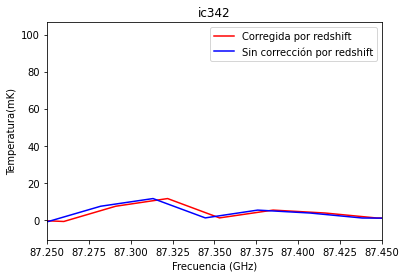

In [336]:
plt.plot(df_corr['frec(GHz)'], df['Temperatura[mK]'],color="red",label= "Corregida por redshift")
plt.plot(df['frec(GHz)'], df['Temperatura[mK]'],color = "blue", label="Sin corrección por redshift")
plt.xlabel('Frecuencia (GHz)')
plt.ylabel('Temperatura(mK)')
plt.title(galaxy)
plt.legend()
#plt.ylim(-1,15)
plt.xlim(87.25,87.45)
plt.show()

In [337]:
# Lee los datos de las frecuencias
tab_frec = pd.read_csv("./galaxias/frecuencias.txt" , header=0, delimiter='\s+')
tab_frec['Rest_Freq'] = round(tab_frec['Rest_Freq'],3 )
tab_frec

,Molecule,Transition,Rest_Freq
0,NS,J=5/3-3/2,115.570
1,CO,J=1-0,115.271
2,C4H,J=25-23,115.216
3,CN,J=3/2-1/2,113.500
4,CN,J=1/2-1/2,113.170
...,...,...,...
159,CH2CN,4-3blend,80.225
160,(CH3)2CO,v=019-18,82.354
161,CH3OCHO,v=018-19,83.574
162,(CH3)2CO,v=018-18,87.682


In [338]:
# Definir el nombre de la molécula de interés
molecule_name = "C2H" #C2H

# Buscar la fila correspondiente a la molécula de interés y obtener el valor de Rest_Freq
rest_freq = tab_frec.loc[tab_frec["Molecule"] == molecule_name, "Rest_Freq"].values[0]

# Se ponen 3 puntos antes y despues del dato en la tabla de frecuencias
lim_inf, lim_sup = rest_freq - 0.1 , rest_freq + 0.167

# enmascarar valores
mask = (df_corr['frec(GHz)'] >= lim_inf) & (df_corr['frec(GHz)'] <= lim_sup)
masked_data = df_corr.loc[mask]

# eliminar filas con valores no finitos
masked_data = masked_data[np.isfinite(masked_data['Temperatura[mK]'])]
masked_data

,frec(GHz),Temperatura[mK],cont_sinlineas
496,87.228,0.310085,5.760650e-02
497,87.260,-0.901079,-1.267000e-01
498,87.291,7.321790,-6.318090e-06
499,87.322,11.464800,-1.192090e-07
500,87.353,1.028940,5.364420e-06
501,87.385,5.234680,-3.576280e-06
502,87.416,3.666940,1.832660e-02
503,87.447,0.969026,4.315020e-03
504,87.479,0.772058,8.711950e-02


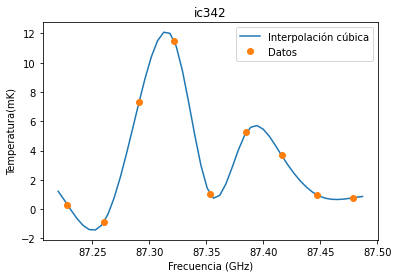

In [339]:
def Cubic_Spline(df_spline,lim_inf, lim_sup):
    # realiza la interpolación cúbica
    adjSpline = CubicSpline(df_spline['frec(GHz)'], df_spline['Temperatura[mK]'],bc_type='natural')
    x_interpolation = np.linspace(lim_inf, lim_sup)
    return x_interpolation, adjSpline

x_CubicSpline, y_CubicSpline = Cubic_Spline(masked_data,lim_inf, lim_sup)
y_CubicSpline = y_CubicSpline(x_CubicSpline)

# grafica los datos interpolados
plt.plot(x_CubicSpline, y_CubicSpline,label= "Interpolación cúbica")
plt.plot(masked_data['frec(GHz)'], masked_data['Temperatura[mK]'],'o',label='Datos')
plt.xlabel('Frecuencia (GHz)')
plt.ylabel('Temperatura(mK)')
plt.title(galaxy)
plt.legend()
plt.show()

In [340]:
"""# Función gaussiana
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

def adj_gaussian(x_data,y_data):
    # Estimación inicial de los parámetros
    a_o = max(y_data)  # Amplitud estimada como el valor máximo de y
    mu_o = x_data[np.argmax(y_data)]  # Media estimada como el valor de X correspondiente al máximo de y
    sigma_o = (max(x_data) - min(x_data)) / 4 

    # Ajuste gaussiano
    params, covariance = curve_fit(gaussian, x_data, y_data, p0=[a_o, mu_o, sigma_o])

    # Parámetros óptimos del ajuste
    a_opt, mu_opt, sigma_opt = params

    # Cálculo de la integral de la gaussiana ajustada
    def integral(x):
        return gaussian(x, a_opt, mu_opt, sigma_opt)

    integral, error = quad(integral, min(x_data), max(x_data))

    # Gráfica de los datos y el ajuste
    plt.scatter(x_data, y_data, label='Interpolación')
    plt.plot(x_data, gaussian(x_data, *params[:3]), 'r-', label='Ajuste gaussiano')
    plt.title(galaxy)
    plt.xlabel('Frecuencia (GHz)')
    plt.ylabel('Temperatura(mK)')
    plt.legend()
    plt.show()

    # Imprimir los parámetros óptimos del ajuste
    print('Parámetros óptimos:')
    print('Amplitud (a):', a_opt)
    print('Media (mu):', mu_opt)
    print('Desviación estándar (sigma):', sigma_opt)

    # Imprimir el resultado de la integral
    print('Resultado de la integral:', integral)

adj_gaussian(x_CubicSpline,y_CubicSpline)"""

"# Función gaussiana\ndef gaussian(x, a, mu, sigma):\n    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))\n\ndef adj_gaussian(x_data,y_data):\n    # Estimación inicial de los parámetros\n    a_o = max(y_data)  # Amplitud estimada como el valor máximo de y\n    mu_o = x_data[np.argmax(y_data)]  # Media estimada como el valor de X correspondiente al máximo de y\n    sigma_o = (max(x_data) - min(x_data)) / 4 \n\n    # Ajuste gaussiano\n    params, covariance = curve_fit(gaussian, x_data, y_data, p0=[a_o, mu_o, sigma_o])\n\n    # Parámetros óptimos del ajuste\n    a_opt, mu_opt, sigma_opt = params\n\n    # Cálculo de la integral de la gaussiana ajustada\n    def integral(x):\n        return gaussian(x, a_opt, mu_opt, sigma_opt)\n\n    integral, error = quad(integral, min(x_data), max(x_data))\n\n    # Gráfica de los datos y el ajuste\n    plt.scatter(x_data, y_data, label='Interpolación')\n    plt.plot(x_data, gaussian(x_data, *params[:3]), 'r-', label='Ajuste gaussiano')\n    plt.title(g

## Ajuste a N-gaussianas

Las funciones gaussianas son adecuadas para describir muchos procesos de las matemáticas, la ciencia y la ingeniería, lo que las hace muy útiles en los campos del procesamiento de señales e imágenes. Por ejemplo, el ruido aleatorio de una señal, inducido por factores físicos complicados, puede modelarse sencillamente con la distribución gaussiana según el teorema del límite central de la teoría de la probabilidad. Otro ejemplo típico en el tratamiento de imágenes es el disco de Airy resultante de la difracción de una abertura circular limitada como la función de dispersión de puntos de un sistema de imágenes. Normalmente, un disco de Airy se representa aproximadamente mediante una función gaussiana bidimensional. Por ello, el ajuste de funciones gaussianas a datos experimentales es muy importante en muchas disciplinas del procesamiento de señales.
Este artículo propone un algoritmo sencillo y mejorado para estimar los parámetros de una función gaussiana ajustada a puntos de datos observados.
# AJUSTE DE CURVAS GAUSSIANAS
Recordemos que una función gaussiana es de la forma
$$
y=A e^{-(x-\mu)^2 / 2 \sigma^2} .
$$
 Esta función puede representarse gráficamente con una curva simétrica en forma de campana centrada en la posición $x=\mu$, con $A$ siendo la amplitud del pico y $\sigma$ controlando su anchura, y a ambos lados del pico las colas (porciones de baja amplitud) de la curva caen rápidamente y se acercan al eje $x$. Este artículo se centra en cómo ajustar una función gaussiana a los puntos de datos observados y determinar con exactitud los parámetros $A, \mu$ y $\sigma$. El método del centroide aprovecha la simetría de una función gaussiana, permitiendo así determinar la posición del pico gaussiano de forma muy eficiente [1], [2]. Aunque este método se utiliza popularmente en el tratamiento de imágenes para la detección de picos subpíxel de un punto o una línea, no permite estimar la anchura o la altura de un pico. En la práctica, no es fácil determinar todos los parámetros gaussianos incluyendo $A, \mu$, y $\sigma$ porque este problema se asocia generalmente con la solución de un sistema sobredeterminado de ecuaciones no lineales, que se genera mediante la sustitución de los datos observados en (1).



In [341]:
def ngaussians(x, *params):
    n = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        amp, mu, sigma = params[i*3:(i+1)*3]
        y += amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return y


p0=[10, 87.25, 0.1,5, 87.4, 0.1]
params, covariance = curve_fit(ngaussians, x_CubicSpline, y_CubicSpline, p0=p0)

perr = np.sqrt(np.diag(covariance))

-------------Curva 1-------------
Amplitud (a) = 12.557 (+/-) 0.349
Media (mu) = 87.312 (+/-) 0.001
Desviación estándar (sigma) = 0.020 (+/-) 0.001
-------------Curva 2-------------
Amplitud (a) = 5.658 (+/-) 0.337
Media (mu) = 87.399 (+/-) 0.001
Desviación estándar (sigma) = 0.021 (+/-) 0.002

Área total = 0.915 (+/-) 0.000


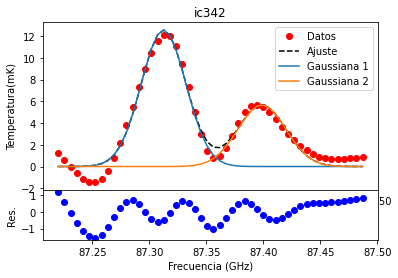

In [342]:
residual = y_CubicSpline - (ngaussians(x_CubicSpline, *params))

fig = plt.figure()
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.30])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace=0) 

ax1.plot(x_CubicSpline, y_CubicSpline, "ro",label="Datos")
ax1.plot(x_CubicSpline, ngaussians(x_CubicSpline, *params), 'k--',label="Ajuste")
for i in range(int(len(params)/3)):
    ax1.plot(x_CubicSpline, ngaussians(x_CubicSpline, *params[i*3:(i+1)*3]), label= "Gaussiana " + str(i+1))
ax2.plot(x_CubicSpline, residual, "bo") # reciduo

ax1.set_title(galaxy)
ax2.set_xlabel('Frecuencia (GHz)')
ax1.set_ylabel('Temperatura(mK)')
ax2.set_ylabel("Res.")
ax1.legend()

fig.savefig("fitGaussian.png", format="png",dpi=1000)

# Cálculo de la integral de la gaussiana ajustada
def integral(x_CubicSpline):
    return ngaussians(x_CubicSpline, *params)
# Iterar sobre cada curva para imprimir los parámetros de ajuste y su error
for i in range(int(len(params)/3)):
    offset = i * 3  # para obtener los índices correctos de los parámetros en params
    print("-------------Curva {}-------------".format(i+1))
    print("Amplitud (a) = %0.3f (+/-) %0.3f" % (params[offset], perr[offset]))
    print("Media (mu) = %0.3f (+/-) %0.3f" % (params[offset+1], perr[offset+1]))
    print("Desviación estándar (sigma) = %0.3f (+/-) %0.3f" % (params[offset+2], perr[offset+2]))
print()


integral, error = quad(integral, min(x_CubicSpline), max(x_CubicSpline))
print("Área total = %0.3f (+/-) %0.3f" % (integral, error))

# Filtro Savitzky–Golay 
Un filtro Savitzky-Golay es un filtro  que se puede aplicar a un conjunto de puntos de datos  con el propósito de suavizar los datos, es decir, aumentar la precisión de los datos sin distorsionar la tendencia de la señal. Esto se logra, en un proceso conocido como convolución, ajustando subconjuntos sucesivos de puntos de datos adyacentes con un polinomio de bajo grado mediante el método de mínimos cuadrados lineales. Cuando los puntos de datos están igualmente espaciados, se puede encontrar una solución analítica a las ecuaciones de mínimos cuadrados en forma de un solo conjunto de "coeficientes de convolución" que se pueden aplicar a todos los subconjuntos de datos para dar estimaciones de la señal suavizada (o derivadas de la señal suavizada) en el punto central de cada subconjunto. El método, basado en procedimientos matemáticos establecidos, fue popularizado por Abraham Savitzky y Marcel J. E. Golay, quienes publicaron tablas de coeficientes de convolución para varios polinomios y tamaños de subconjuntos en 1964.

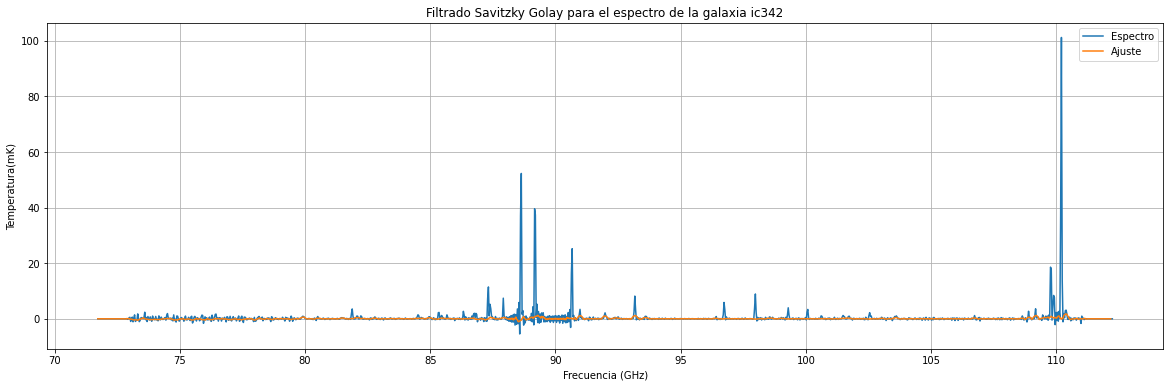

In [343]:
import numpy as np
import pandas as pd
from scipy import signal

df = df_corr.copy()
# Dividir el dataframe original en 10 secciones
num_sections = 5
section_size = len(df) // num_sections

# Crear una lista para almacenar los dataframes modificados
modified_dfs = []

# Aplicar el código en cada sección del dataframe original
for i in range(num_sections):
    start_idx = i * section_size
    end_idx = (i + 1) * section_size

    # Obtener la sección correspondiente del dataframe original
    df_section = df[start_idx:end_idx].copy()

    # Calcular la desviación estándar de la columna 'Temperatura[mK]' en la sección actual
    std_dev = np.std(df_section['Temperatura[mK]'])

    # Aplicar el código para establecer los valores en cero si son mayores que la desviación estándar
    df_section.loc[df_section['Temperatura[mK]'] > std_dev, 'Temperatura[mK]'] = 0

    # Agregar la sección modificada a la lista
    modified_dfs.append(df_section)

# Concatenar todos los dataframes modificados en uno solo
df_modified = pd.concat(modified_dfs)

# Aplicar el suavizado de la columna 'Temperatura[mK]' en la sección actual
df_modified['Temperatura[mK]'] = signal.savgol_filter(df_modified['Temperatura[mK]'],window_length=11,polyorder=3,mode="nearest")

# Obtener las columnas 'frec(GHz)' y 'Temperatura[mK]' del dataframe modificado
x_modified = df_modified['frec(GHz)']
y_modified = df_modified['Temperatura[mK]']

plt.figure(figsize=(20, 6))
plt.plot(df_corr['frec(GHz)'], df['Temperatura[mK]'], label="Espectro")
plt.plot(x_modified, y_modified,  label="Ajuste")
plt.xlabel('Frecuencia (GHz)')
plt.ylabel('Temperatura(mK)')
plt.title("Filtrado Savitzky Golay para el espectro de la galaxia "+ galaxy)
plt.legend()
plt.grid(True)
plt.show()

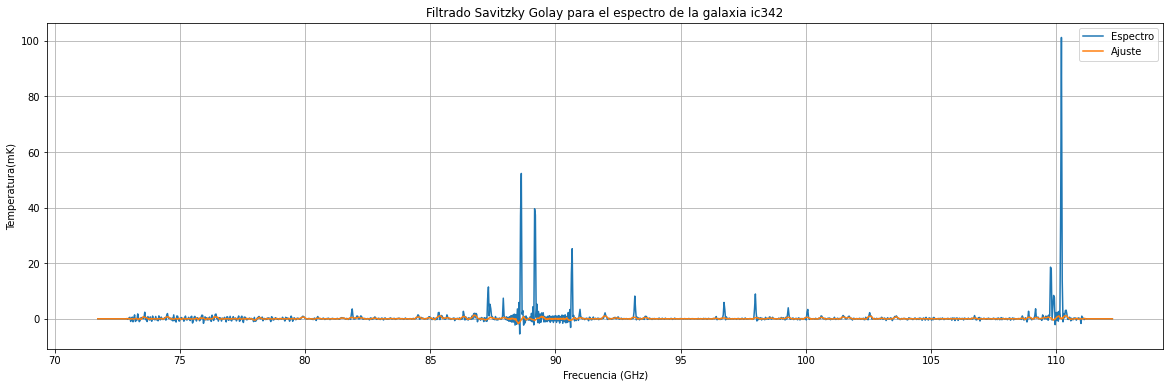

In [344]:
from scipy import signal

df_masked = df_corr.copy()
# Reemplazamos los valores mayores a 10 de 'Temperatura[mK]' por 0
df_masked.loc[df_masked['Temperatura[mK]'] >3, 'Temperatura[mK]'] = 0

x = df_corr['frec(GHz)']
y =  df['Temperatura[mK]']
 
y_smooth = signal.savgol_filter(df_masked['Temperatura[mK]'], window_length=11, polyorder=3, mode="nearest")
    
plt.figure(figsize=(20, 6))
plt.plot(df_corr['frec(GHz)'], df['Temperatura[mK]'], label="Espectro")
plt.plot(df_corr['frec(GHz)'], y_smooth,  label="Ajuste")
plt.xlabel('Frecuencia (GHz)')
plt.ylabel('Temperatura(mK)')
plt.title("Filtrado Savitzky Golay para el espectro de la galaxia "+ galaxy)
plt.legend()
plt.grid(True)
plt.show()

El parámetro window_length en el método de ajuste Savitzky-Golay en Python se refiere al tamaño de la ventana de suavizado. La ventana se desliza sobre los datos y se ajusta un polinomio a los puntos dentro de la ventana. El tamaño de la ventana determina cuántos puntos se incluyen en el ajuste del polinomio.

Un valor más grande de window_length dará como resultado una suavización más suave, pero puede perder detalles finos en los datos. Por otro lado, un valor más pequeño de window_length dará como resultado una suavización más agresiva, pero puede mantener detalles finos en los datos.

In [345]:
# Filtrar los datos que se llaman HC3N
mol_data = tab_frec[tab_frec['Molecule'] == 'HC3N']
mol_data

,Molecule,Transition,Rest_Freq
20,HC3N,J=12-11v7,109.600
21,HC3N,J=12-11v7,109.440
22,HC3N,J=12-11,109.173
29,HC3N,J=12-11v7,100.470
30,HC3N,J=12-11v7,100.320
31,HC3N,J=11-10,100.076
42,HC3N,J=10-9v7,91.330
43,HC3N,J=10-9v7,91.200
44,HC3N,J=10-9,90.979
65,HC3N,J=9-8v7,82.200


In [346]:
# Crear un diccionario para almacenar los datos
datos_dict = {}
# Leer la columna "Transition" y "Rest_Freq" y almacenarlos en el diccionario
for index, row in mol_data.iterrows():
    transition, rest_freq = row["Transition"], row["Rest_Freq"] #Se obtienen los datos de las transiciones y sus frecuencias
    
    if transition not in datos_dict:
        datos_dict[transition] = [rest_freq]
    else:
        datos_dict[transition].append(rest_freq)

datos_dict

{'J=12-11v7': [109.6, 109.44, 100.47, 100.32],
 'J=12-11': [109.173],
 'J=11-10': [100.076],
 'J=10-9v7': [91.33, 91.2],
 'J=10-9': [90.979],
 'J=9-8v7': [82.2, 82.08],
 'J=9-8': [81.88]}

In [347]:
# Iterar a través del diccionario datos_dict
for transition, rest_freqs in datos_dict.items():
    df_null = pd.DataFrame({'frec(GHz)':[],'Temperatura[mK]':[],'cont_sinlineas':[]})
    print('-----'*5,"Transición:", transition, '-----'*5)
    for val_frec in rest_freqs: 
        # Enmascara los datos desde el valor central a 3 datos delante y 3 detras.
        lim_inf, lim_sup = val_frec - 0.1 , val_frec + 0.1
        masked_Dataf = df[(df['frec(GHz)'] > lim_inf) & (df['frec(GHz)'] < lim_sup)]

        # Concatena los DataFrames verticalmente
        df_null = pd.concat([df_null, masked_Dataf], ignore_index=True)
        
        # Elimina las filas duplicadas basadas en los valores de las columnas
        df_null = df_null.drop_duplicates()
        
        if len(rest_freqs) >= 2:
            print(masked_Dataf  )
            print()

    print(df_null)

    # Filtrar las filas que tienen el valor máximo en la columna "Temperatura[mK]"
    max_ta = df_null.loc[df_null['Temperatura[mK]'] == df_null['Temperatura[mK]'].max()]

    # Obtener el valor de la columna "frec(GHz)" de la fila resultante
    frec_max_ta = max_ta['frec(GHz)'].values[0]
    print("El valor máximo de la frecuencia:", frec_max_ta,'para una temperatura de', max_ta['Temperatura[mK]'].values[0])
    print()
     

------------------------- Transición: J=12-11v7 -------------------------
      frec(GHz)  Temperatura[mK]  cont_sinlineas
1209    109.512         0.105343        0.105343
1210    109.543        -0.037888        0.034695
1211    109.574         0.961457       -0.036989
1212    109.606        -0.073441       -0.135576
1213    109.637         0.994267        0.018946
1214    109.668        -0.508304        0.037952
1215    109.699         1.358100        0.020125

      frec(GHz)  Temperatura[mK]  cont_sinlineas
1204    109.356        -0.042977       -0.042977
1205    109.387        -0.204355       -0.031649
1206    109.418        -0.568088       -0.027461
1207    109.449         1.400410       -0.010566
1208    109.481         0.685385        0.003448
1209    109.512         0.105343        0.105343

     frec(GHz)  Temperatura[mK]  cont_sinlineas
917    100.386         0.202445        0.202445
918    100.417        -0.036878       -0.036878
919    100.448        -0.134190       -0.1341

In [348]:
# Definir los DataFrames
df1 = pd.DataFrame({
    'frec(GHz)': [109.512, 109.543, 109.574, 109.606, 109.637, 109.668, 109.699],
    'Temperatura[mK]': [0.105343, -0.037888, 0.961457, -0.073441, 0.994267, -0.508304, 1.358100],
    'cont_sinlineas': [0.105343, 0.034695, -0.036989, -0.135576, 0.018946, 0.037952, 0.020125]
})

df2 = pd.DataFrame({
    'frec(GHz)': [109.356, 109.387, 109.418, 109.449, 109.481, 109.512],
    'Temperatura[mK]': [-0.042977, -0.204355, -0.568088, 1.400410, 0.685385, 0.105343],
    'cont_sinlineas': [-0.042977, -0.031649, -0.027461, -0.010566, 0.003448, 0.105343]
})

df3 = pd.DataFrame({
    'frec(GHz)': [100.386, 100.417, 100.448, 100.480, 100.511, 100.542],
    'Temperatura[mK]': [0.202445, -0.036878, -0.134190, -0.065778, 0.226311, 0.026760],
    'cont_sinlineas': [0.202445, -0.036878, -0.134190, -0.065778, 0.226311, 0.026760]
})



In [361]:
Table_Data, Full_Data = ['Species', 'Freq-GHz(rest frame,redshifted)', 'Resolved QNs','CDMS/JPL Intensity'], []
df_MoleculeData_com = pd.DataFrame(Full_Data, columns=Table_Data)

Molecule,  Transition, Rest_Freq = 'CH30H', '0-1', 108.894
val_min, val_max = Rest_Freq - 2, Rest_Freq + 2

try:
    # Consultar las líneas
    Chemical_molecule = Splatalogue.query_lines(val_min*u.GHz, val_max*u.GHz, line_lists=['CDMS', 'JPL'], chemical_name=' '+Molecule+' ')

    # Recorrer las filas y agregar los datos a la lista
    for row in Chemical_molecule:
        if row['Freq-GHz(rest frame,redshifted)'] != '--':
            Full_Data.append([row[column] for column in Table_Data])
    df_MoleculeData = pd.DataFrame(Full_Data, columns=Table_Data)

    # Eliminar el "v=0" de cada Species y los valores para "F="
    df_MoleculeData['Species'], df_MoleculeData['Freq-GHz(rest frame,redshifted)'] = df_MoleculeData['Species'].str.replace("v=0", ""), df_MoleculeData['Freq-GHz(rest frame,redshifted)'].round(3).astype(str)
    df_MoleculeData['Resolved QNs'] = df_MoleculeData['Resolved QNs'].str.split(',&Omega').str[0].str.split(',p=').str[0].str.split(',F=').str[0].str.split(',l=').str[0]

    df_MoleculeData_transition = df_MoleculeData[df_MoleculeData['Resolved QNs'] == Transition]

    if df_MoleculeData_transition.empty:
        df_MoleculeData_transition = df_MoleculeData[df_MoleculeData['Resolved QNs'].str.contains(Transition)]

    df_MoleculeData_com = pd.concat([df_MoleculeData_com, pd.DataFrame([df_MoleculeData.loc[df_MoleculeData['Freq-GHz(rest frame,redshifted)'].astype(float).sub(Rest_Freq).abs().idxmin()]], columns=df_MoleculeData.columns)])
    df_MoleculeData_com
except ValueError:
        print(f"No se han encontrado los datos para: {Molecule,Transition,Rest_Freq}.")


No se han encontrado los datos para: ('CH30H', '0-1', 108.894).


In [360]:
Table_Data, Full_Data = ['Species','Chemical Name', 'Freq-GHz(rest frame,redshifted)', 'Resolved QNs','CDMS/JPL Intensity'], []
df_MoleculeData_com = pd.DataFrame(Full_Data, columns=Table_Data)

for index, row in tab_frec.iterrows():
    Molecule, Transition, Rest_Freq  = row['Molecule'], row['Transition'], row['Rest_Freq']
    val_min, val_max = Rest_Freq - 2, Rest_Freq + 2

    try: 
        # Consultar las líneas
        Chemical_molecule = Splatalogue.query_lines(val_min*u.GHz, val_max*u.GHz, line_lists=['CDMS', 'JPL'], chemical_name=' '+Molecule+' ')

        # Recorrer las filas y agregar los datos a la lista
        for row in Chemical_molecule:
            if row['Freq-GHz(rest frame,redshifted)'] != '--':
                Full_Data.append([row[column] for column in Table_Data])
        df_MoleculeData = pd.DataFrame(Full_Data, columns=Table_Data)

        # Eliminar el "v=0" de cada Species y los valores para "F="
        df_MoleculeData['Species'], df_MoleculeData['Freq-GHz(rest frame,redshifted)'] = df_MoleculeData['Species'].str.replace("v=0", ""), df_MoleculeData['Freq-GHz(rest frame,redshifted)'].round(3).astype(str)
        df_MoleculeData['Resolved QNs'] = df_MoleculeData['Resolved QNs'].str.split(',&Omega').str[0].str.split(',p=').str[0].str.split(',F=').str[0].str.split(',l=').str[0]

        df_MoleculeData_transition = df_MoleculeData[df_MoleculeData['Resolved QNs'] == Transition]

        if df_MoleculeData_transition.empty:
            df_MoleculeData_transition = df_MoleculeData[df_MoleculeData['Resolved QNs'].str.contains(Transition)]

        df_MoleculeData_com = pd.concat([df_MoleculeData_com, pd.DataFrame([df_MoleculeData.loc[df_MoleculeData['Freq-GHz(rest frame,redshifted)'].astype(float).sub(Rest_Freq).abs().idxmin()]], columns=df_MoleculeData.columns)])
    except ValueError:
        print(f"No se han encontrado los datos para: {Molecule,Transition,Rest_Freq}.")
        continue
    
        
df_MoleculeData_com

No se han encontrado los datos para: ('NS', 'J=5/3-3/2', 115.57).
No se han encontrado los datos para: ('CH4', 'J=23/2-21/2', 113.266).
No se han encontrado los datos para: ('CH30H', '0-1', 108.894).
No se han encontrado los datos para: ('H', '39ALPHA', 106.737).
No se han encontrado los datos para: ('CH3C2H', 'BLEND', 102.547).
No se han encontrado los datos para: ('S0', '3-2', 99.3).
No se han encontrado los datos para: ('H', '40ALPHA', 99.023).


C:\Users\Alejandro Yg\AppData\Local\Temp\ipykernel_24560\1782786376.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_MoleculeData_transition = df_MoleculeData[df_MoleculeData['Resolved QNs'].str.contains(Transition)]


No se han encontrado los datos para: ('N2H+', 'J=1-0', 93.174).
No se han encontrado los datos para: ('H', '41ALPHA', 92.034).
No se han encontrado los datos para: ('HOC+', 'J=1-0', 89.487).
No se han encontrado los datos para: ('C2H', 'blend', 87.32).
No se han encontrado los datos para: ('C2H', 'blend', 87.407).
No se han encontrado los datos para: ('C2H', 'blend', 87.446).
No se han encontrado los datos para: ('Si0', '2-1', 86.847).
No se han encontrado los datos para: ('H13CO+', 'J=1-0', 86.754).
No se han encontrado los datos para: ('H', '42ALPHA', 85.688).
No se han encontrado los datos para: ('CH3C2H', 'BLEND', 85.456).
No se han encontrado los datos para: ('C3H2', '2-1', 85.339).
No se han encontrado los datos para: ('H', '43alpha', 79.913).
No se han encontrado los datos para: ('H', '44alpha', 74.645).
No se han encontrado los datos para: ('U', '27-26', 82.787).
No se han encontrado los datos para: ('HCCCCN', 'blend', 92.09).
No se han encontrado los datos para: ('HCCCCN', 'bl

,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity
0,COv=1,Carbon Monoxide,114.222,1-0,-9.7069
26,C4Hv7=1,"1,3-Butadiynyl radical",115.217,"N=12,J=25/2-23/2",-3.8952
45,CN,Cyanide Radical,113.5,"N=1-0,J=3/2-1/2",-3.7962
41,CN,Cyanide Radical,113.17,"N=1-0,J=1/2-1/2",-3.8090
43,CN,Cyanide Radical,113.488,"N=1-0,J=3/2-1/2",-3.6932
...,...,...,...,...,...
5065,CH3CH2CN,Ethyl Cyanide,89.564,"10(7,3)-9(7,2)",-6.5541
2872,CH3OCHO,Methyl Formate,90.453,"57(22,35)-56(23,34)A",-7.7908
1556,CH2CN,Cyanomethyl,80.225,"4(3,2)-3(3,1),J+F=5-4,S=6-6",-4.9804
1093,CH3OHvt=0-2,Methanol,83.637,30(14)-31(16)E1vt=1-vt=0,-10.0435
